<a href="https://colab.research.google.com/github/mudmemeshiba/GenderClassification/blob/main/Enhanced_Gender_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Setting Up Drive

In [4]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -la /content/drive/MyDrive/y3/deep

total 275895
drwx------ 2 root root      4096 Nov  3 13:12 dataset
-rw------- 1 root root 282512091 Nov  2 19:41 Dataset.zip


In [ ]:
#   !unzip "/content/drive/MyDrive/y3/deep/Dataset.zip" -d "/content/dataset" #Unzip file from drive
!unzip "/content/Dataset.zip" -d "/content/dataset" #Unzip file from drive

In [5]:
!nvidia-smi -L || true  # ดูว่าได้ GPU ไหม (บน Colab)
import torch, platform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__)
print("Device :", device, "| Python:", platform.python_version())

GPU 0: Tesla T4 (UUID: GPU-0784f1a6-aee5-f449-4353-cdaeaaee543b)
PyTorch: 2.8.0+cu126
Device : cuda | Python: 3.12.12


In [6]:
import os, time, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# ตั้งค่า device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Path dataset, config as needed
# BASE_DIR  = "/content/drive/MyDrive/y3/deep/dataset"
BASE_DIR  = "/content/dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "Training")
TEST_DIR  = os.path.join(BASE_DIR, "Validation")

# Paramete/r
IMG_SIZE   = 224
BATCH_SIZE = 32
SEED       = 1337
torch.manual_seed(SEED)

Device: cuda


## Transform & Dataset

In [7]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

# โหลด dataset
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
class_names = full_train.classes
num_classes = len(class_names)
print("Classes:", class_names)

# แบ่ง train/val
val_ratio = 0.2
num_total = len(full_train)
indices = np.arange(num_total)
np.random.seed(SEED); np.random.shuffle(indices)
val_size = int(num_total * val_ratio)
val_idx, train_idx = indices[:val_size], indices[val_size:]

train_subset = torch.utils.data.Subset(full_train, train_idx)
val_subset   = torch.utils.data.Subset(
    datasets.ImageFolder(TRAIN_DIR, transform=test_tfms), val_idx)

test_set = datasets.ImageFolder(TEST_DIR, transform=test_tfms)


Classes: ['female', 'male']


## Class Imbalance

In [8]:
targets = np.array([full_train.samples[i][1] for i in train_idx])
class_count = np.bincount(targets, minlength=num_classes)
class_weights = 1.0 / (class_count + 1e-6)
sample_weights = class_weights[targets]
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

## Data Loader

In [9]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True)


# Model

In [10]:
import torch
import torch.nn as nn

class MiniCNN(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),      # 224 -> 112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),      # 112 -> 56

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2),      # 56 -> 28
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # -> (128,1,1)
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ใช้งาน
model = MiniCNN(num_classes=1).to(device)


## Loss, Optimizer, Scheduler

In [11]:
criterion = nn.BCEWithLogitsLoss()   # Binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2)

## Train/Validate

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def epoch_run(loader, train_mode=True):
    if train_mode: model.train()
    else: model.eval()

    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(imgs).squeeze(1)
                loss = criterion(logits, labels)

            if train_mode:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        preds = (torch.sigmoid(logits) >= 0.5).long()
        running_loss += loss.item() * imgs.size(0)
        correct += (preds.cpu() == labels.long().cpu()).sum().item()
        total += imgs.size(0)

    return running_loss/total, correct/total


/tmp/ipython-input-4143029229.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


## Training Loop

In [13]:
def train_model(epochs=10, patience=3):
    best_w = copy.deepcopy(model.state_dict())
    best_acc = 0
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    no_improve = 0

    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = epoch_run(train_loader, True)
        val_loss, val_acc = epoch_run(val_loader, False)
        scheduler.step(val_loss)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {ep:02d}: "
              f"Train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"Val loss {val_loss:.4f} acc {val_acc:.4f} | "
              f"Time {time.time()-t0:.1f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            best_w = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "/content/best_minicnn.pth")
            print("  ↳ Saved new best model")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_w)
    return history

history = train_model(epochs=10, patience=3)


/tmp/ipython-input-4143029229.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01: Train loss 0.6338 acc 0.6453 | Val loss 0.6135 acc 0.6781 | Time 173.8s
  ↳ Saved new best model
Epoch 02: Train loss 0.5831 acc 0.7015 | Val loss 0.5441 acc 0.7325 | Time 159.9s
  ↳ Saved new best model
Epoch 03: Train loss 0.5397 acc 0.7363 | Val loss 0.5712 acc 0.7048 | Time 154.9s
Epoch 04: Train loss 0.5003 acc 0.7687 | Val loss 0.4515 acc 0.8109 | Time 160.5s
  ↳ Saved new best model
Epoch 05: Train loss 0.4685 acc 0.7841 | Val loss 0.4591 acc 0.7887 | Time 155.8s
Epoch 06: Train loss 0.4484 acc 0.8000 | Val loss 0.4063 acc 0.8309 | Time 159.5s
  ↳ Saved new best model
Epoch 07: Train loss 0.4232 acc 0.8120 | Val loss 0.3801 acc 0.8451 | Time 155.6s
  ↳ Saved new best model
Epoch 08: Train loss 0.4134 acc 0.8175 | Val loss 0.3648 acc 0.8596 | Time 157.4s
  ↳ Saved new best model
Epoch 09: Train loss 0.4012 acc 0.8233 | Val loss 0.3426 acc 0.8649 | Time 155.8s
  ↳ Saved new best model
Epoch 10: Train loss 0.3964 acc 0.8260 | Val loss 0.3471 acc 0.8596 | Time 154.8s


## Test set Evaluation

In [14]:
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs).squeeze(1)
        all_logits.append(logits.cpu())
        all_labels.append(labels.float())

logits = torch.cat(all_logits)
labels = torch.cat(all_labels)
probs = torch.sigmoid(logits).numpy()
preds = (probs >= 0.5).astype(int)

print(classification_report(labels.numpy().astype(int), preds, target_names=class_names))

cm = confusion_matrix(labels.numpy().astype(int), preds)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

      female       0.89      0.83      0.86      5841
        male       0.84      0.90      0.87      5808

    accuracy                           0.86     11649
   macro avg       0.87      0.87      0.86     11649
weighted avg       0.87      0.86      0.86     11649

Confusion matrix:
 [[4848  993]
 [ 580 5228]]


## Confusion Matrix

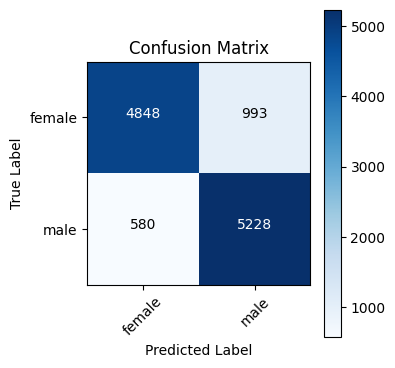

In [15]:
def plot_cm(cm, classes):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

plot_cm(cm, class_names)


## Inference

In [19]:
from PIL import Image

def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = test_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x).squeeze(1)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= 0.5)
    return class_names[pred], prob

print(predict_image("/content/interence/45210.jpg"))


('female', 0.04073137044906616)


## Sentence